### Vehicle Detection & Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Implement a sliding-window technique and use the trained linear classifier to search for vehicles in images.
* Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [16]:
#Import all required packages
import numpy as np
import cv2,time,glob
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline

### 0. User-defined & lesson Functions

In [32]:
#Read images from folders and return a image list
def ReadOImgs(root):
    import os
    datalist=[]
    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.endswith('.png') or name.endswith('.jpeg'):
                imgpath=os.path.join(path, name)
                datalist.append(imgpath)
    return datalist


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 


# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist


# Define a function to extract features from a list of images
def batch_img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = batch_img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = batch_img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors


def compare2fig(img1,img2,title1,title2,cmap1='gray',cmap2='gray'):
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.subplot(122)
    plt.imshow(img2, cmap=cmap2)
    plt.title(title2)

### 1. Feed in data & exploratory data analysis

1. Raw data volume about cars & notcars
cars: 8792 , Notcars: 10093
2. Exploratory Data Visualization: Plot a random pair of car & notcar:


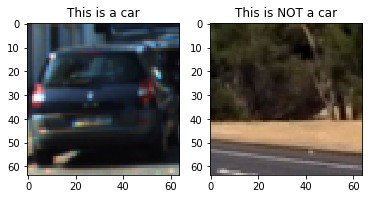

In [25]:
cars=ReadOImgs("./data/vehicles")
notcars=ReadOImgs("./data/non-vehicles")
print("1. Raw data volume about cars & notcars")
print("cars: {} , Notcars: {}".format(len(cars), len(notcars)))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 8500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
#print("2.Sample data volume about cars & notcars")
#print("cars: {} , Notcars: {}".format(len(cars), len(notcars)))

# Exploratory Data Visualization: Plot a random pair of car & notcar
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Feed in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
print("2. Exploratory Data Visualization: Plot a random pair of car & notcar:")
compare2fig(car_image,notcar_image,"This is a car","This is NOT a car",cmap1=None,cmap2=None)

### 2. Feature Extractions: various methods

* Histograms of color
* Bin Spatial
* Histogram of Oriented Gradients (HOG)

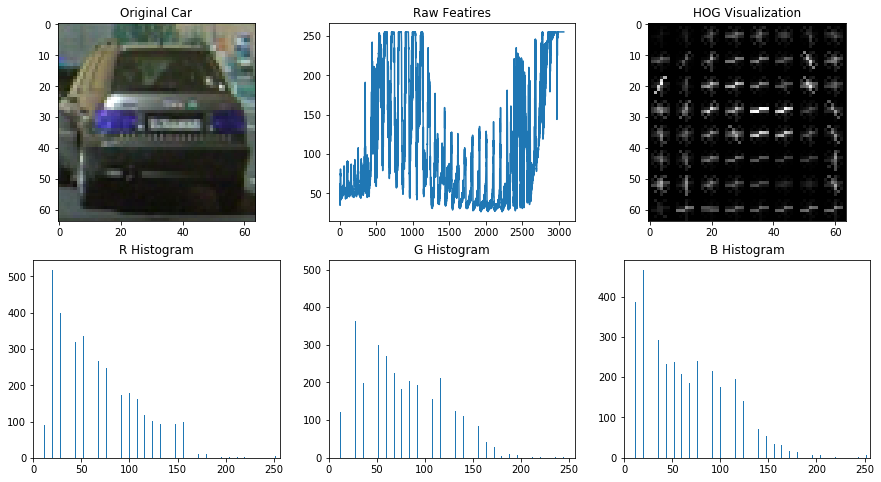

In [62]:
# Histograms of Color
car_ind = np.random.randint(0, len(cars))
FEimg = cv2.imread(cars[car_ind])
nbins=32
bins_range=(0, 256)
rhist = np.histogram(FEimg[:,:,0], bins=nbins, range=bins_range)
ghist = np.histogram(FEimg[:,:,1], bins=nbins, range=bins_range)
bhist = np.histogram(FEimg[:,:,2], bins=nbins, range=bins_range)
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

# Bin Spatial for raw features
BS_feature_image = np.copy(FEimg)
raw_features = cv2.resize(BS_feature_image, (32,32)).ravel() 

# Histogram of Oriented Gradients (HOG)
gray = cv2.cvtColor(FEimg, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# start plotting
fig = plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(FEimg)
plt.title('Original Car')
plt.subplot(232)
plt.plot(BS_features)
plt.title('Raw Featires')
plt.subplot(233)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(234)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(235)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(236)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')


### 3. Training the classification Model

In [4]:
# Define parameters for feature extraction
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [5]:
def train_svc_model(cars, notcars):
    # feed in cars and notcars
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    print("car feature shape: {} , ncr feature shape: {}".format(len(car_features),len(notcar_features)))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('Linear SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    
    return X_scaler, svc

In [6]:
X_scaler, svc=train_svc_model(cars, notcars)

car feature shape: 17584 , ncr feature shape: 20186
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
9.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9866
Linear SVC predicts:  [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.]


### 4. Sliding Windows

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

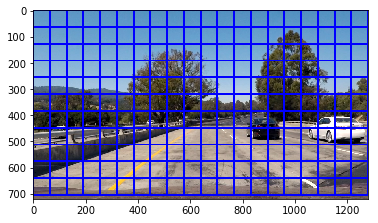

In [64]:
timage = mpimg.imread('test_images/test1.jpg')
windows = slide_window(timage, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(timage, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### 5. Find cars by search & classification

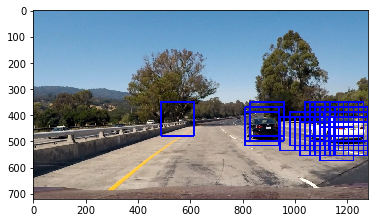

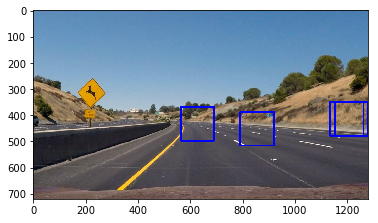

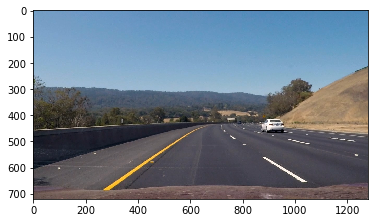

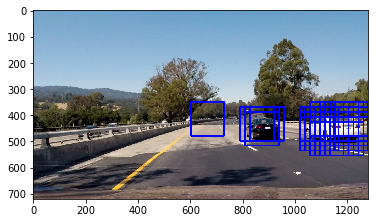

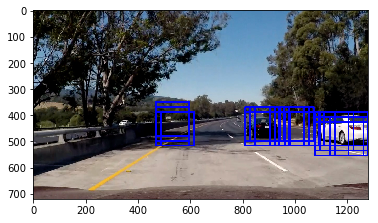

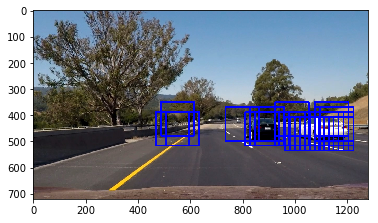

In [8]:
def find_car(image):  
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[450, None], y_start_stop=[350, 620], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    return hot_windows,window_img

test_images = glob.glob('test_images/*.jpg')    
for timg in test_images:
    fig = plt.figure()
    image = mpimg.imread(timg)
    hot_windows,window_img=find_car(image)
    plt.imshow(window_img)

### 6. A more advanced method: Heat Maps

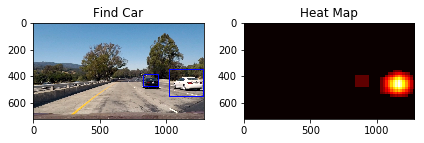

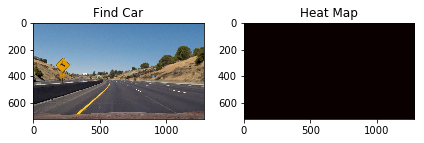

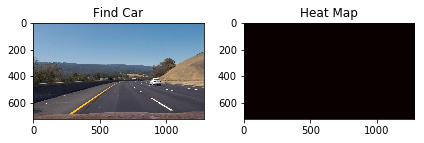

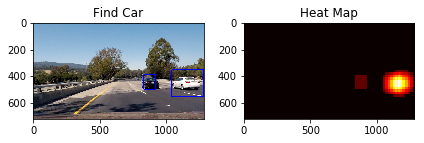

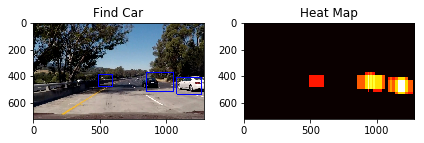

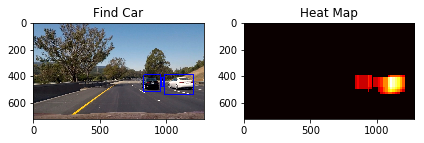

In [9]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



#cars=ReadOImgs("./data/vehicles")
#notcars=ReadOImgs("./data/non-vehicles")
#X_scaler, svc=train_svc_model(cars, notcars)
test_images = glob.glob('test_images/*.jpg')

for timg in test_images:
    fig = plt.figure()
    image = mpimg.imread(timg)
    hot_windows,window_img=find_car(image)
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Find Car')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

### 7. Video processing & Pipeline

In [10]:
from moviepy.editor import VideoFileClip

def process_frame(image):
    hot_windows,window_img=find_car(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, 3)   
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

video_output = 'test_output.mp4'
clip = VideoFileClip("test_video.mp4")
white_clip = clip.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:27<00:00,  2.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [ ]:
video_output = 'Project_output.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)